<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/vasicekTransitionMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings
import statsmodels.api as sm

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from datetime import timedelta
from scipy.special import logit, expit
from scipy.stats import norm

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
warnings.filterwarnings('ignore') #Disable warning
plt.style.use('seaborn-deep') #Plot style

In [3]:
# Define plot matrix function
def plotMatrix(data, plotName):
  plt.figure(figsize = (14, 9))
  plt.title(f'{plotName}')
  ax = sns.heatmap(
      data,
      annot = True,
      fmt = '.2%',
      xticklabels = True,
      yticklabels = True,
      cmap = 'RdYlGn_r',
      cbar = False
  )
  ax.xaxis.tick_top() # x-axis on top
  ax.xaxis.set_label_position('top')
  return plt.show()

In [4]:
# Import dataset of count rating
df = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/ratingMatrix.csv'
)

# Apply ever default
df['Rating12'] = np.where(
    df['Rating'] == 'Default',
    'Default',
    df['Rating12']
)

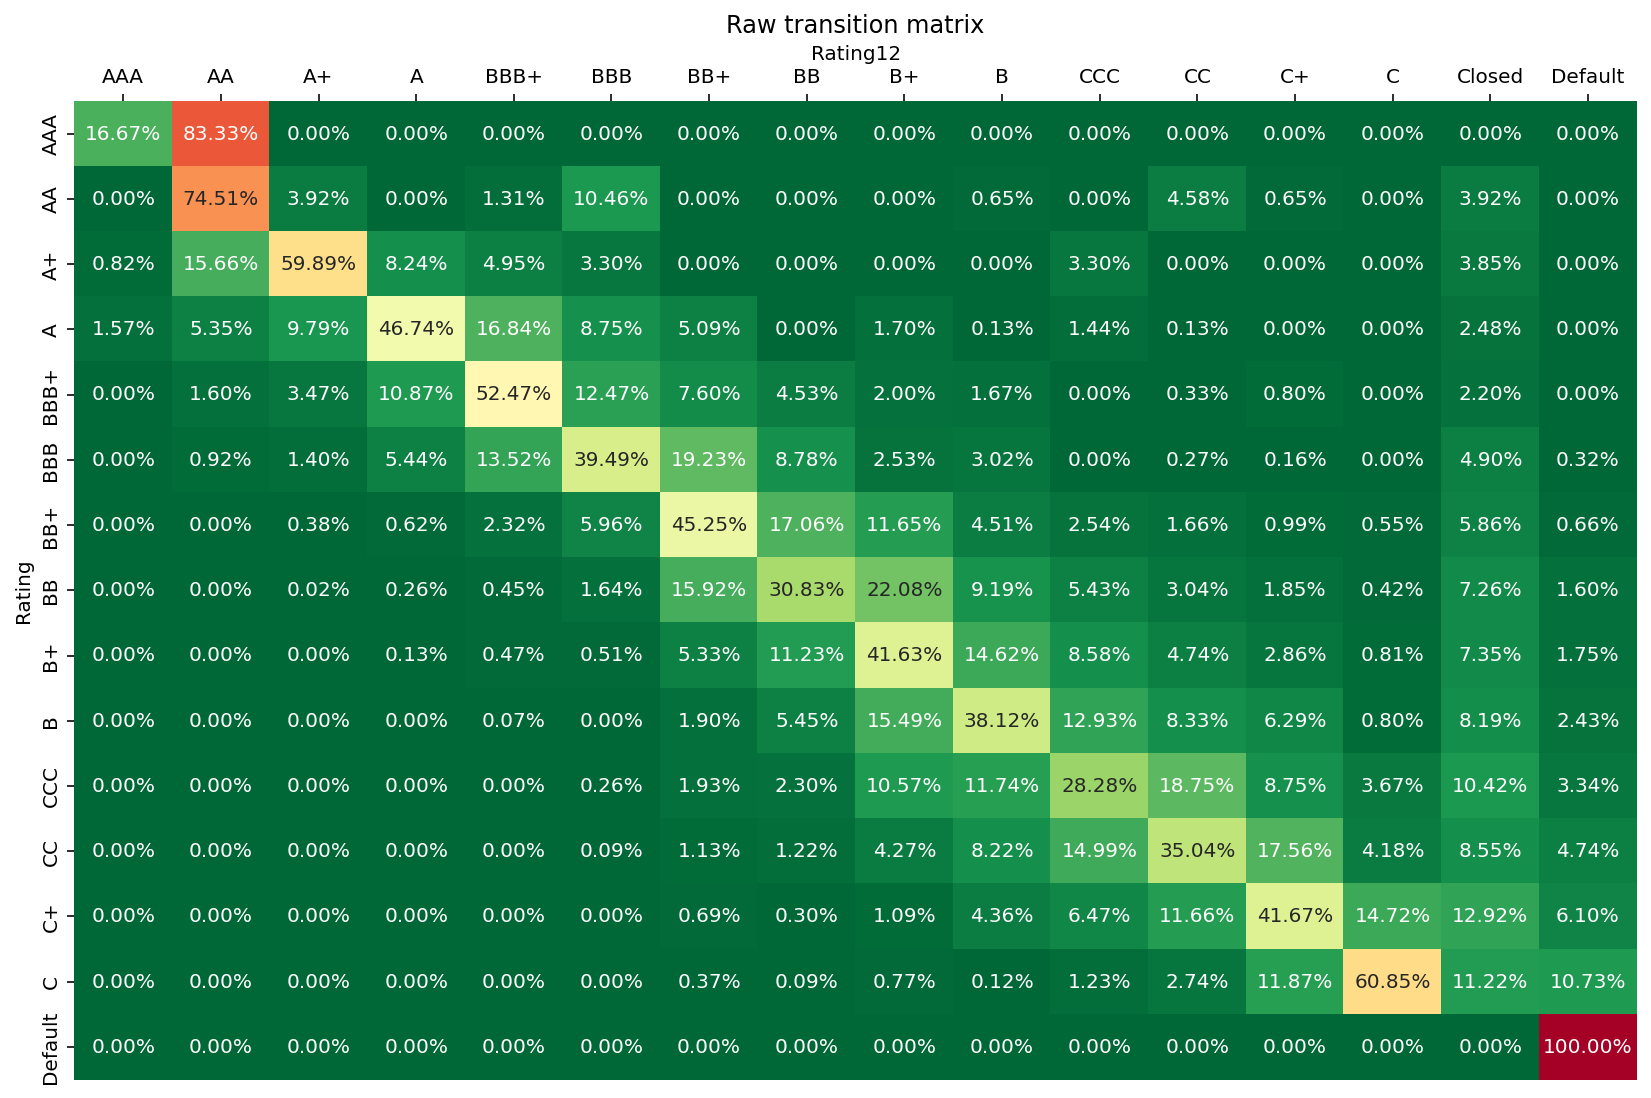

In [5]:
# Define index and columns by rating
colsRating = [
              'AAA', 'AA', 'A+', 'A', 'BBB+', 'BBB', 'BB+', 'BB', 'B+',
               'B', 'CCC', 'CC', 'C+', 'C', 'Closed', 'Default'
]

indexRating = [
               'AAA', 'AA', 'A+', 'A', 'BBB+', 'BBB', 'BB+', 'BB', 'B+',
               'B', 'CCC', 'CC', 'C+', 'C', 'Default'
]


# Apply ever default
# Covert to count transition
matrix = pd.pivot_table(
    df,
    values = 'N',
    index = ['Rating'],
    columns = ['Rating12'],
    aggfunc = sum
).fillna(0)

# Format matrix
matrix = matrix[colsRating] #Sort columns
matrix.index = matrix.index.str.strip()
matrix = matrix.reindex(indexRating) #Sort index

# To transition matrix
matrix = matrix.div(matrix.sum(axis = 1), axis = 0)

# Plot
plotMatrix(matrix, 'Raw transition matrix')

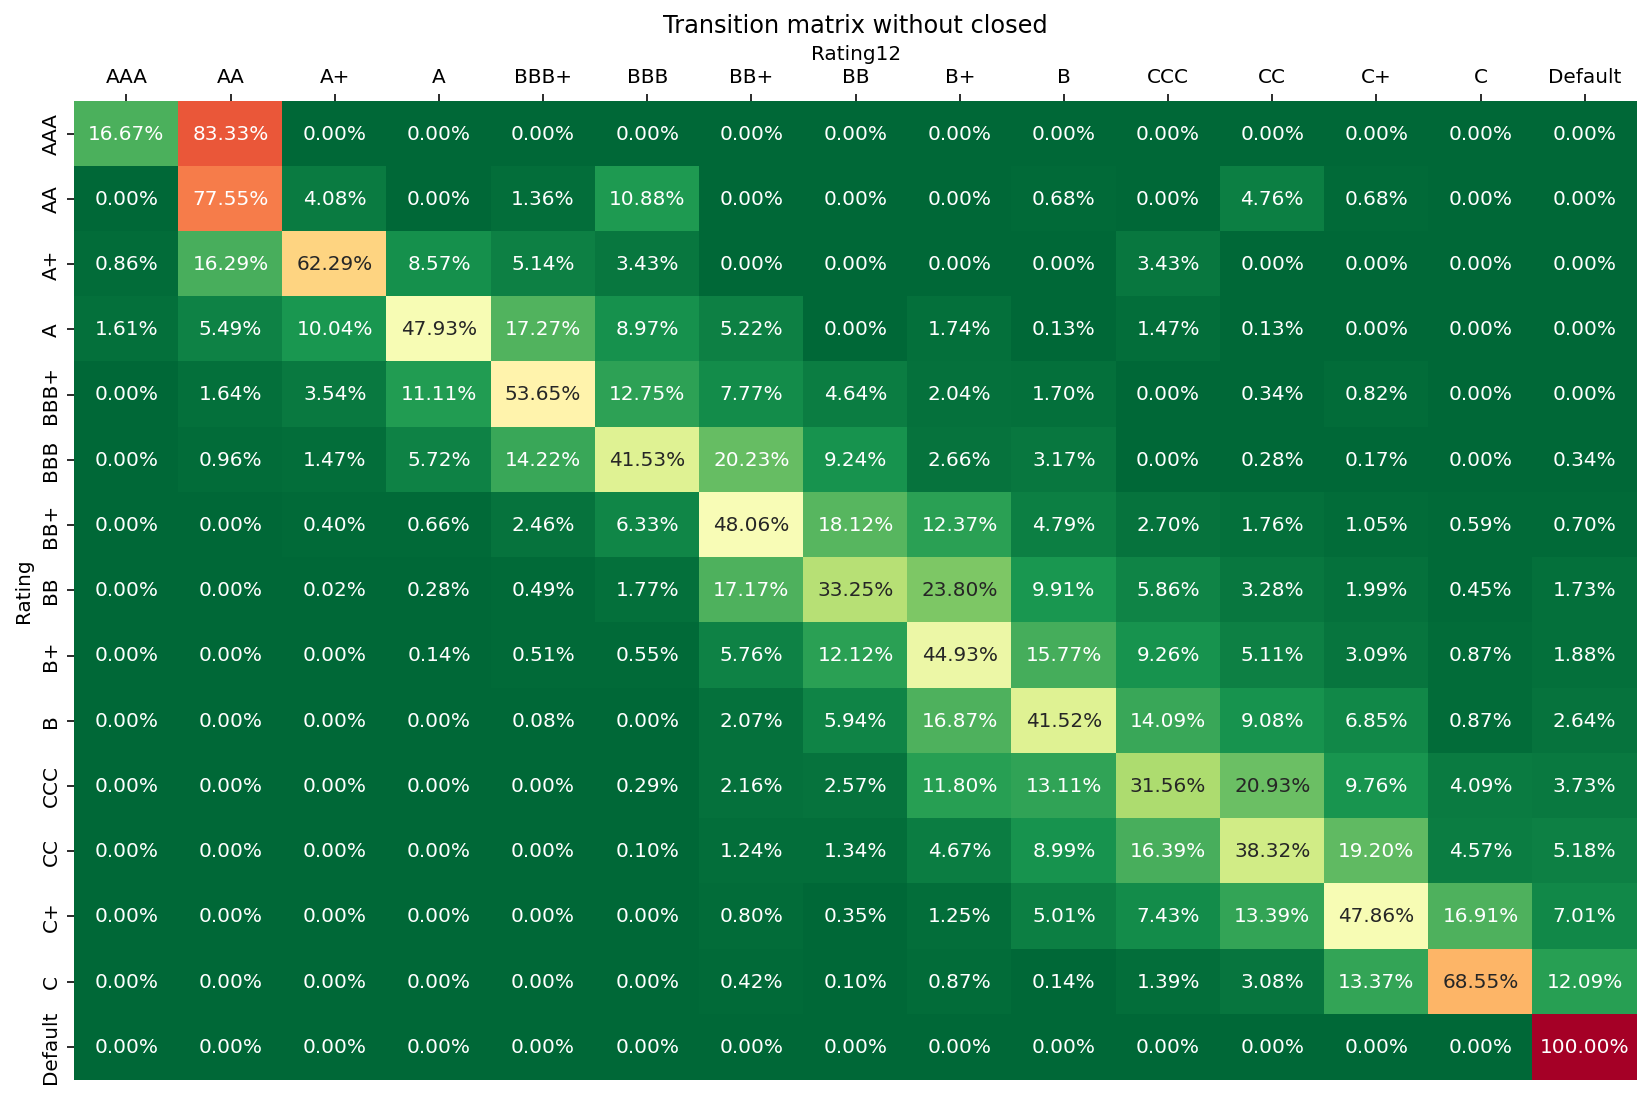

In [6]:
# Matrix adjusted by remove closed rate
matrix = matrix.drop(
    ['Closed'],
    axis = 1
).div(
    1 - matrix['Closed'],
    axis = 0
)

# Plot
plotMatrix(matrix, 'Transition matrix without closed')

In [7]:
# Fitting polynomial regression
poly = PolynomialFeatures(degree = 2)
smoothingModel = LinearRegression()

# Data for regression
X = np.arange(1, len(matrix['Default'][:-1]) + 1).reshape(-1, 1)
y = np.where(
    matrix['Default'][:-1] == 0,
    logit(0.00001),
    logit(matrix['Default'][:-1])
)

XPoly = poly.fit_transform(X)

# Fitting
smoothingModel.fit(XPoly, y)

LinearRegression()

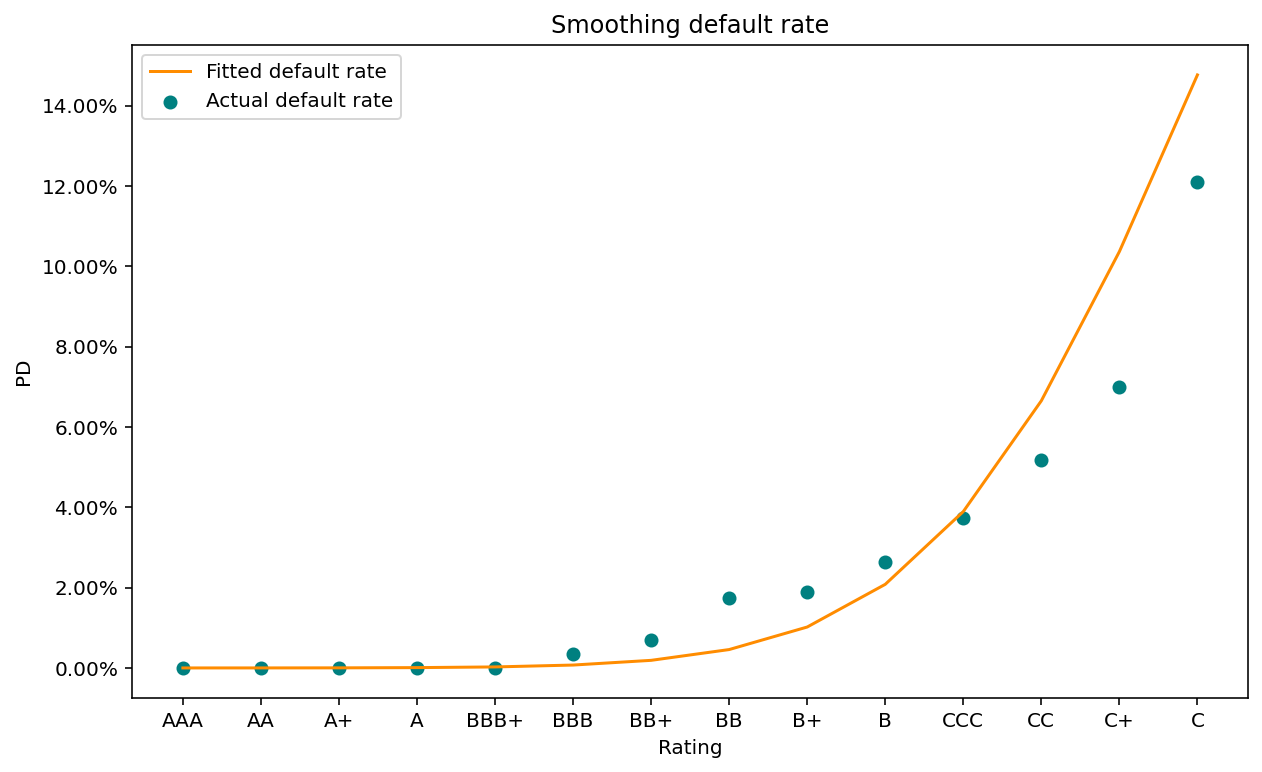

In [8]:
# Plot
plt.figure(figsize = (10, 6))
plt.scatter(
    matrix.index[:-1],
    matrix['Default'][:-1],
    color = 'teal',
    label = 'Actual default rate'
)
plt.plot(
    expit(smoothingModel.predict(XPoly)),
    color = 'darkorange',
    label = 'Fitted default rate'
)
plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])
plt.title('Smoothing default rate')
plt.xlabel('Rating')
plt.ylabel('PD')
plt.legend(frameon = True, facecolor = 'white')
plt.show()

In [9]:
# Define function rate matrix adjustment
def adjMatrix(data, oldRate, newRate):
  adjRate = (1 - data[newRate]).values / (1 - data[oldRate]).values
  matrixAdj = data.drop(
      [oldRate, newRate],
      axis = 1
  ).mul(
      adjRate,
      axis = 0
  ).fillna(0)
  matrixAdj[f'{newRate}'] = list(data[newRate])
  return matrixAdj

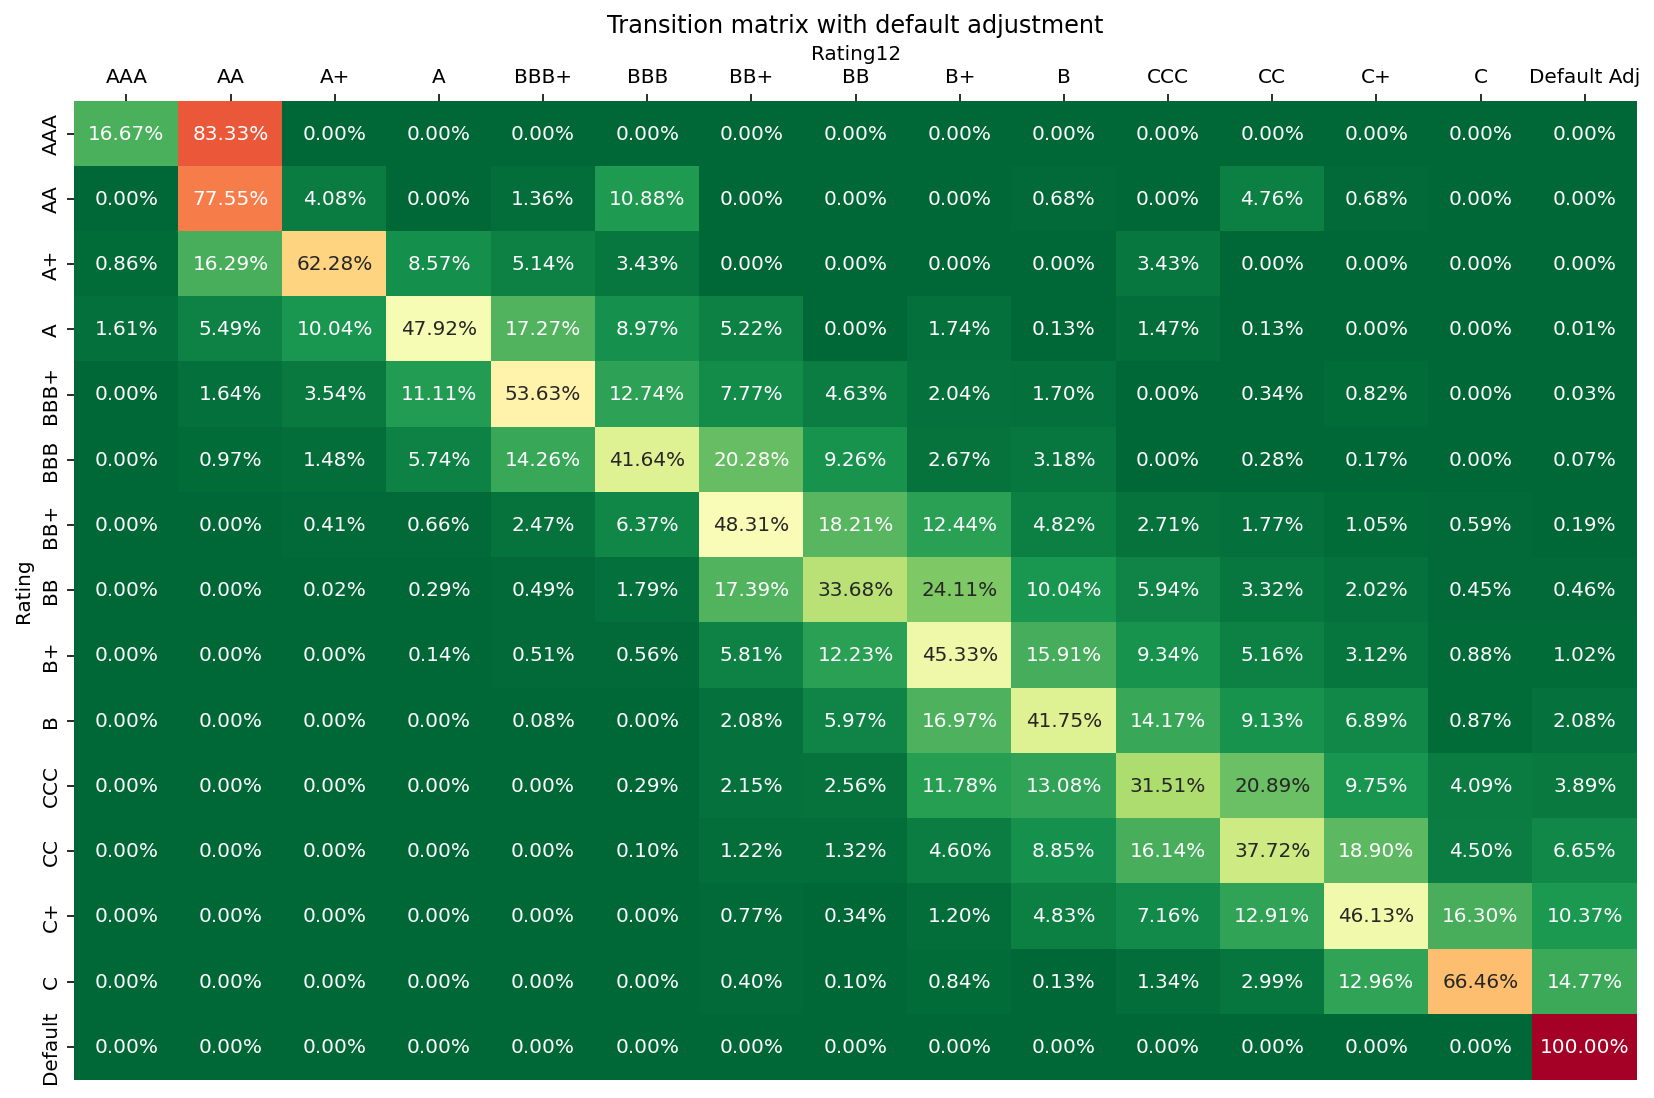

In [10]:
# Add fitted default rate
matrix['Default Adj'] = np.hstack(
    (expit(smoothingModel.predict(XPoly)), 1)
) #Stack with 100% Default rate

# Matrix adjusted by default rate adjustment
matrix = adjMatrix(matrix, 'Default', 'Default Adj')

# Plot
plotMatrix(matrix, 'Transition matrix with default adjustment')

### Vasicek model
Single factor approach uses **Vasicek-Merton Model** to compute Point-In-Time (PIT) based on the TTC PD and the state of the economy ***(asset correlation)***. The model relies on a distance to default assumption whereby the probability of default is linked to the probability that an asset values drop below a default threshold which is derived from the amount owed on the loan.

The default threshold is inferred from the PD by applying the standard normal inverse distribution function. The model measures how many standard deviations the current asset value is higher than the current debt level. While applying the Vasicek model, an asset correlation factor is used to capture the correlation between the movements in the asset value with the economy. The asset value will deteriorate in an economy that worsen which will in turn cause the whole distribution curve to shift and the default rate to increase due to increased area under the curve.

Apply the single-factor model Vasicek approach. This can be applied to portfolios that already had TTC PDs from unbias model. The Vasicek approach can be then used to obtain the forward-looking PiT PD using the adjusted CF. This can incorporate the forward-looking infomration into unbias model.

The below equation is to calculate PiT PD using Vasicek approach:

\begin{align}
        PD_{PiT, i} = \Phi\left(\frac{\Phi^{-1}(PD_{TTC, i}) + \sqrt{\rho} * CF'}{\sqrt{1 - \rho}}\right)
    \end{align}

where;
- $\Phi$ is the standard normal function
- $\Phi^{-1}$ is the inverse of the standard normal function
- $PD_{TTC, i}$ is the unbias TTC PD from the rating model or scoring model
- $\rho$ is the Basel asset correlation
- $CF'$ is the Cycle Conversion Factor, which is the standardised idiosyncratic risk factor at the current point in the economic cycle

The **Cycle Conversion Factor (CF)** is developed by regressing **the normal inverse of the historical ODR** ($\Phi^{-1}$) with the macroeconomics variables. The form of standardised of the CF, which is used in Vasicek equation can be found below:

\begin{align}
        CF' = \frac{CF - \mu}{\sigma}
    \end{align}

where;
- $\mu$ = $\frac{\Phi^{-1}(PD_{TTC})}{\sqrt{1 - \rho}}$
- $\sigma$ = $\frac{\sqrt{\rho}}{\sqrt{1 - \rho}}$

Note: The $PD_{TTC}$ is from the regression model **NOT** the unbias model.

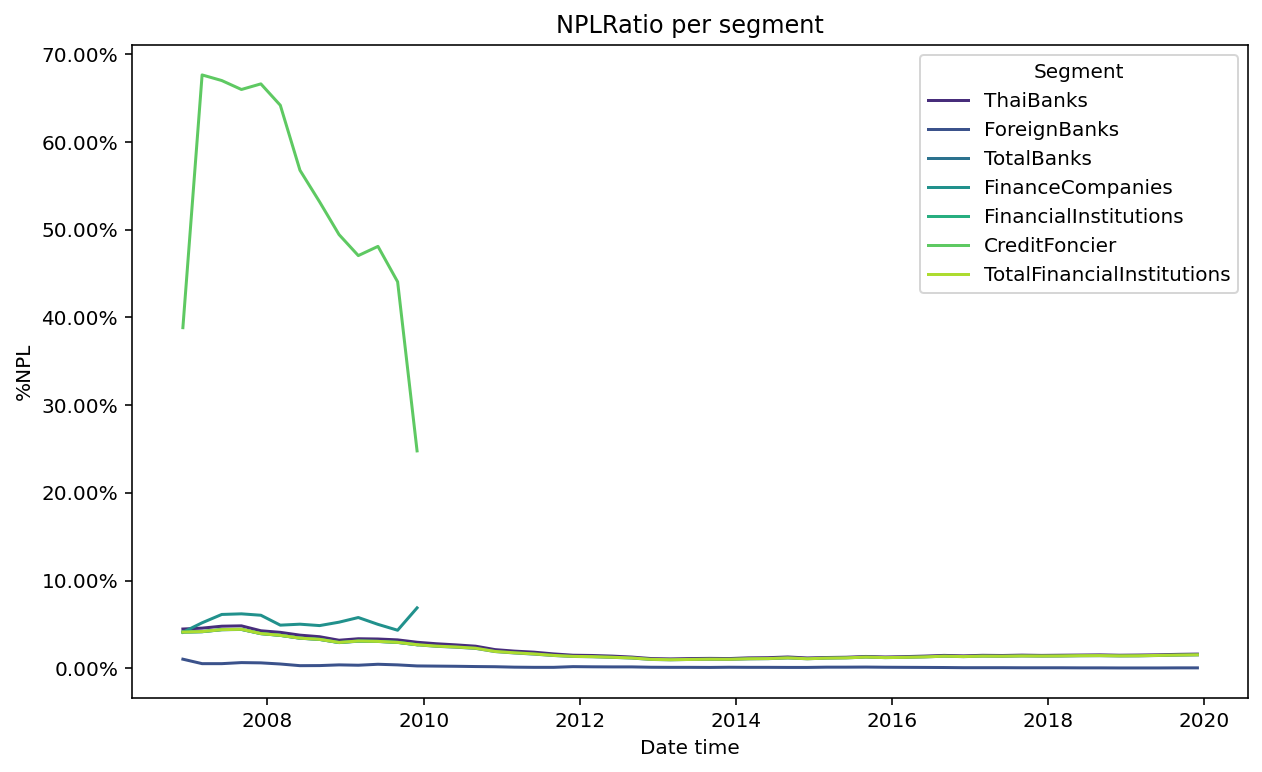

In [11]:
# Import dataset
nplRatio = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/bankNPLRatio.csv',
    parse_dates = ['Date'],
)

# Select not null 'NPLRatio'
nplRatio = nplRatio[nplRatio['NPLRatio'].notnull()]

# Plot
plt.figure(figsize = (10, 6))
ax = sns.lineplot(
  x = 'Date',
  y = 'NPLRatio',
  data = nplRatio,
  hue = 'Segment',
  legend = 'full',
  palette = 'viridis',
  ci = None
)
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: '{0:.2f}%'.format(x * 100))
)
ax.set_title('NPLRatio per segment')
ax.set(xlabel = 'Date time', ylabel = '%NPL')
plt.show()

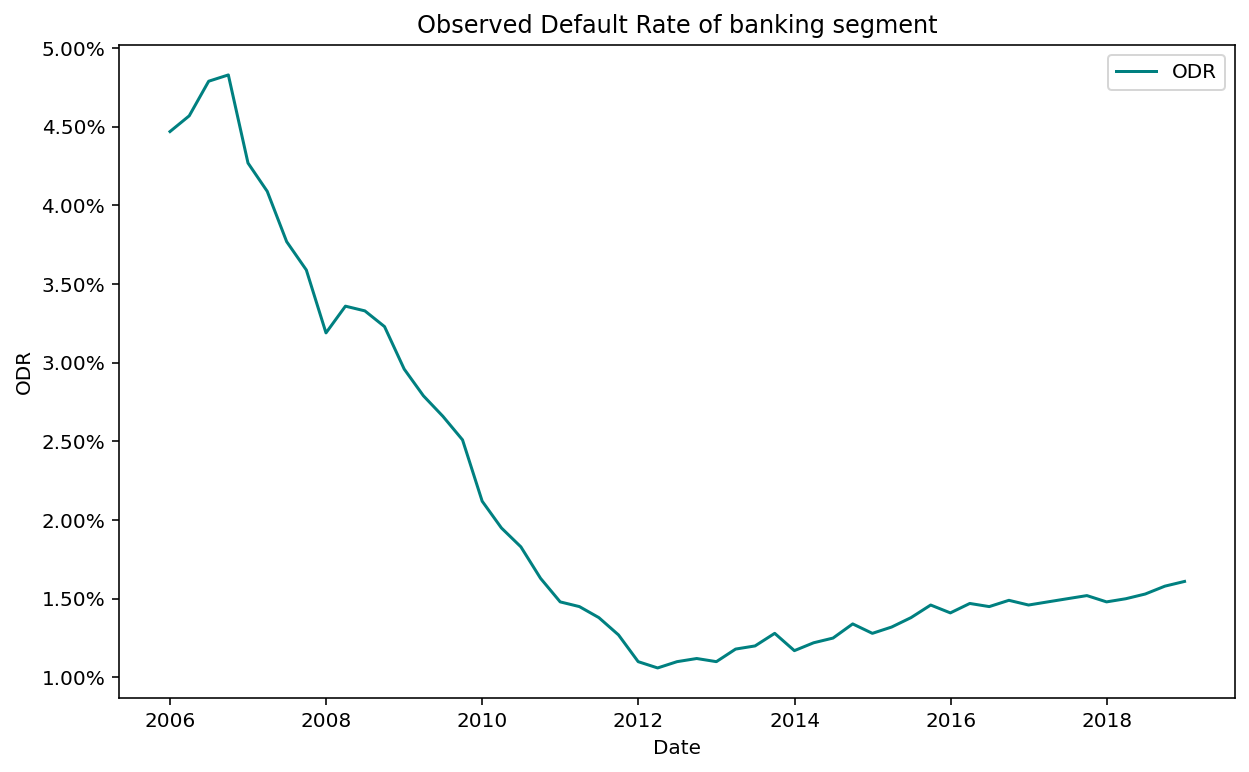

In [12]:
# Select only 'Bank' Sector
odr = nplRatio.query(
    "Segment == 'ThaiBanks'"
).rename(
    columns = {'NPLRatio': 'ODR'}
)

# Using 12-Months lag for probability creation
'''
The data is the NPL Ratio on particular period.
Thus, by lagging of 12-Months will be the probability of event to occur.
'''
odr['Date'] = odr['Date'] - timedelta(days = 1 * 365) + pd.offsets.MonthEnd() #1-Year ago

# Plot
plt.figure(figsize = (10, 6))
plt.plot(
    odr['Date'],
    odr['ODR'],
    color = 'teal',
    label = 'ODR'
)
plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])
plt.title('Observed Default Rate of banking segment')
plt.xlabel('Date')
plt.ylabel('ODR')
plt.legend(frameon = True, facecolor = 'white')
plt.show()

In [13]:
# Import macroeconomics data
mevSelected = ['GDP_C_lg12', 'RSI_C_lg5', 'CPI_M9_lg6']

mev = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/macroTransformed.csv',
    parse_dates = ['Date']
)
mev['Date'] = mev['Date'] + pd.offsets.MonthEnd()
mev = mev.set_index('Date')[mevSelected]

# Mapping MEV
FWLData = pd.merge(
    odr[['Date', 'Amount', 'ODR']],
    mev.reset_index(),
    how = 'left',
    left_on = ['Date'],
    right_on = ['Date']
).set_index('Date')

# Drop missing value
FWLData = FWLData[FWLData.iloc[:, 2].notnull()]

# Show table
FWLData.head(5)

,Amount,ODR,GDP_C_lg12,RSI_C_lg5,CPI_M9_lg6
Date,,,,,
2014-03-31,147207.0,0.0122,0.052505,-0.089583,98.838889
2014-06-30,151787.0,0.0125,0.026890,-0.098612,99.236667
2014-09-30,160736.0,0.0134,0.024592,-0.050642,99.733333
2014-12-31,156245.0,0.0128,0.002041,-0.055042,100.440000
2015-03-31,164564.0,0.0132,-0.003716,-0.019957,100.973333


In [14]:
# Forward-looking model
X = sm.add_constant(
    FWLData[mevSelected],
    has_constant = 'add'
)
y = norm.ppf(FWLData['ODR']) #Z-Index
FWLModel = sm.OLS(y, X).fit()

# Model summary
print(FWLModel.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     13.87
Date:                Sat, 12 Mar 2022   Prob (F-statistic):           0.000134
Time:                        11:34:11   Log-Likelihood:                 53.695
No. Observations:                  19   AIC:                            -99.39
Df Residuals:                      15   BIC:                            -95.61
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6996      1.531     -1.764      0.0

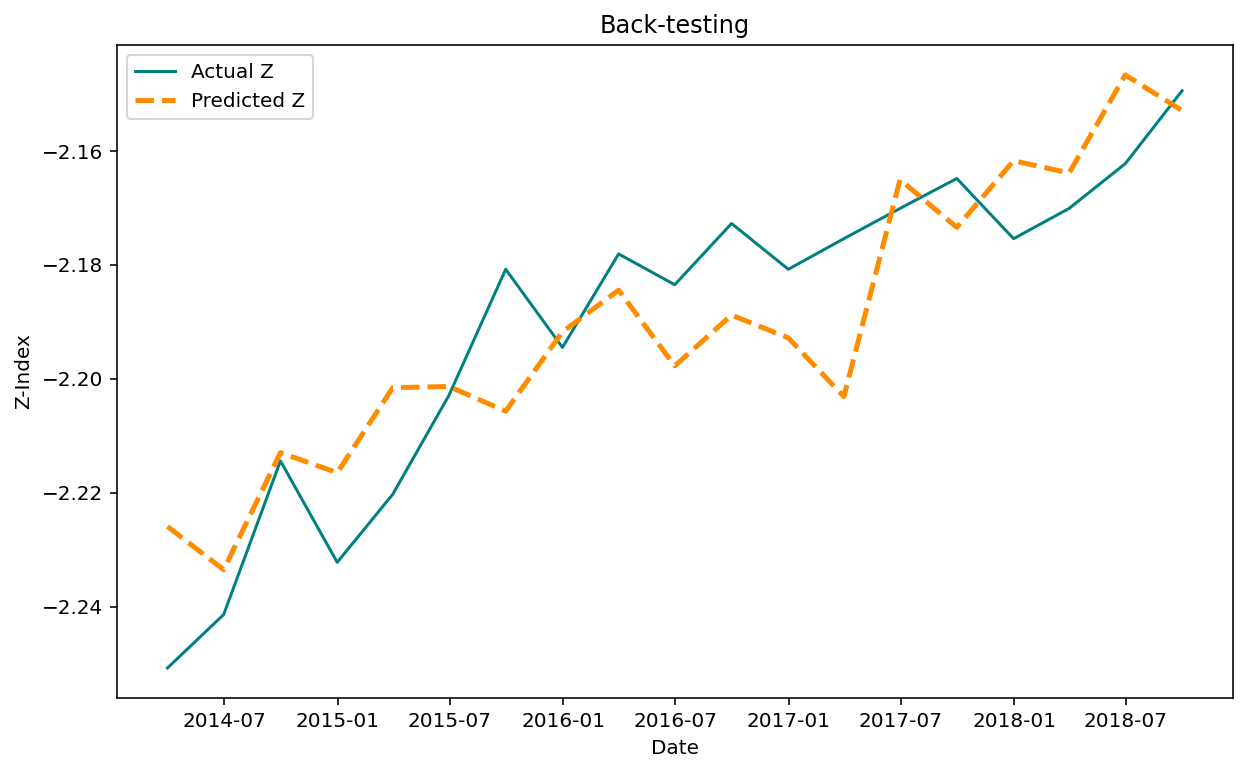

In [15]:
# Back-testing
plt.figure(figsize = (10, 6))
plt.plot(
    X.index,
    y,
    c = 'teal',
    label = 'Actual Z'
)
plt.plot(
    X.index,
    FWLModel.predict(X),
    c = 'darkorange',
    linewidth = 2.5,
    linestyle = '--',
    label = 'Predicted Z'
    
)
plt.title('Back-testing')
plt.xlabel('Date')
plt.ylabel('Z-Index')
plt.legend(frameon = True, facecolor = 'white')
plt.show()

In [16]:
# Forecast for 3 years starting at 2018-12
# Assumed macroeconomics variables
XForecast = np.array(
    [
     [1, 0.055, 0.045, 102.1],
     [1, 0.045, 0.07, 101.5],
     [1, 0.076, 0.06, 103.6]
    ]
)

# Z-Index prediction
ZPred = FWLModel.predict(XForecast)
print(f'Predicted Z-Index\n{ZPred}')

Predicted Z-Index
[-2.1567599  -2.15244609 -2.13842363]


In [17]:
# Vasicek model parameters
# TTC PD
TTC = expit(smoothingModel.predict(XPoly))

# Asset correlation on each rating
rho = 0.22765 #Assumed to be constand

# Z-Index (Standardized)
mean = norm.ppf(
    np.average(
        FWLData['ODR'],
        weights = FWLData['Amount'],
        axis = 0
    )
) / np.sqrt(1 - rho)
std = np.sqrt(rho) / np.sqrt(1 - rho)

ZSTD = (ZPred - mean) / std #Standardized with in-time data

In [18]:
# Vasicek PD
vasicekPD = []

for i in range(3):
  vasPD = norm.cdf(
      (
          norm.ppf(TTC) + np.sqrt(rho) * ZSTD[i]
      ) / np.sqrt(1 - rho)
  )
  vasicekPD.append(vasPD)

In [19]:
# Adjust matrix with Vasicek PD
matrixForecast = []

for i in range(3):
  matrixAdj = matrix.copy()
  matrixAdj['Vasicek PD'] = np.hstack(
      (vasicekPD[i], 1)
  ) #Stack with 100% Default rate
  matrixAdj = adjMatrix(matrixAdj, 'Default Adj', 'Vasicek PD')
  matrixForecast.append(matrixAdj)

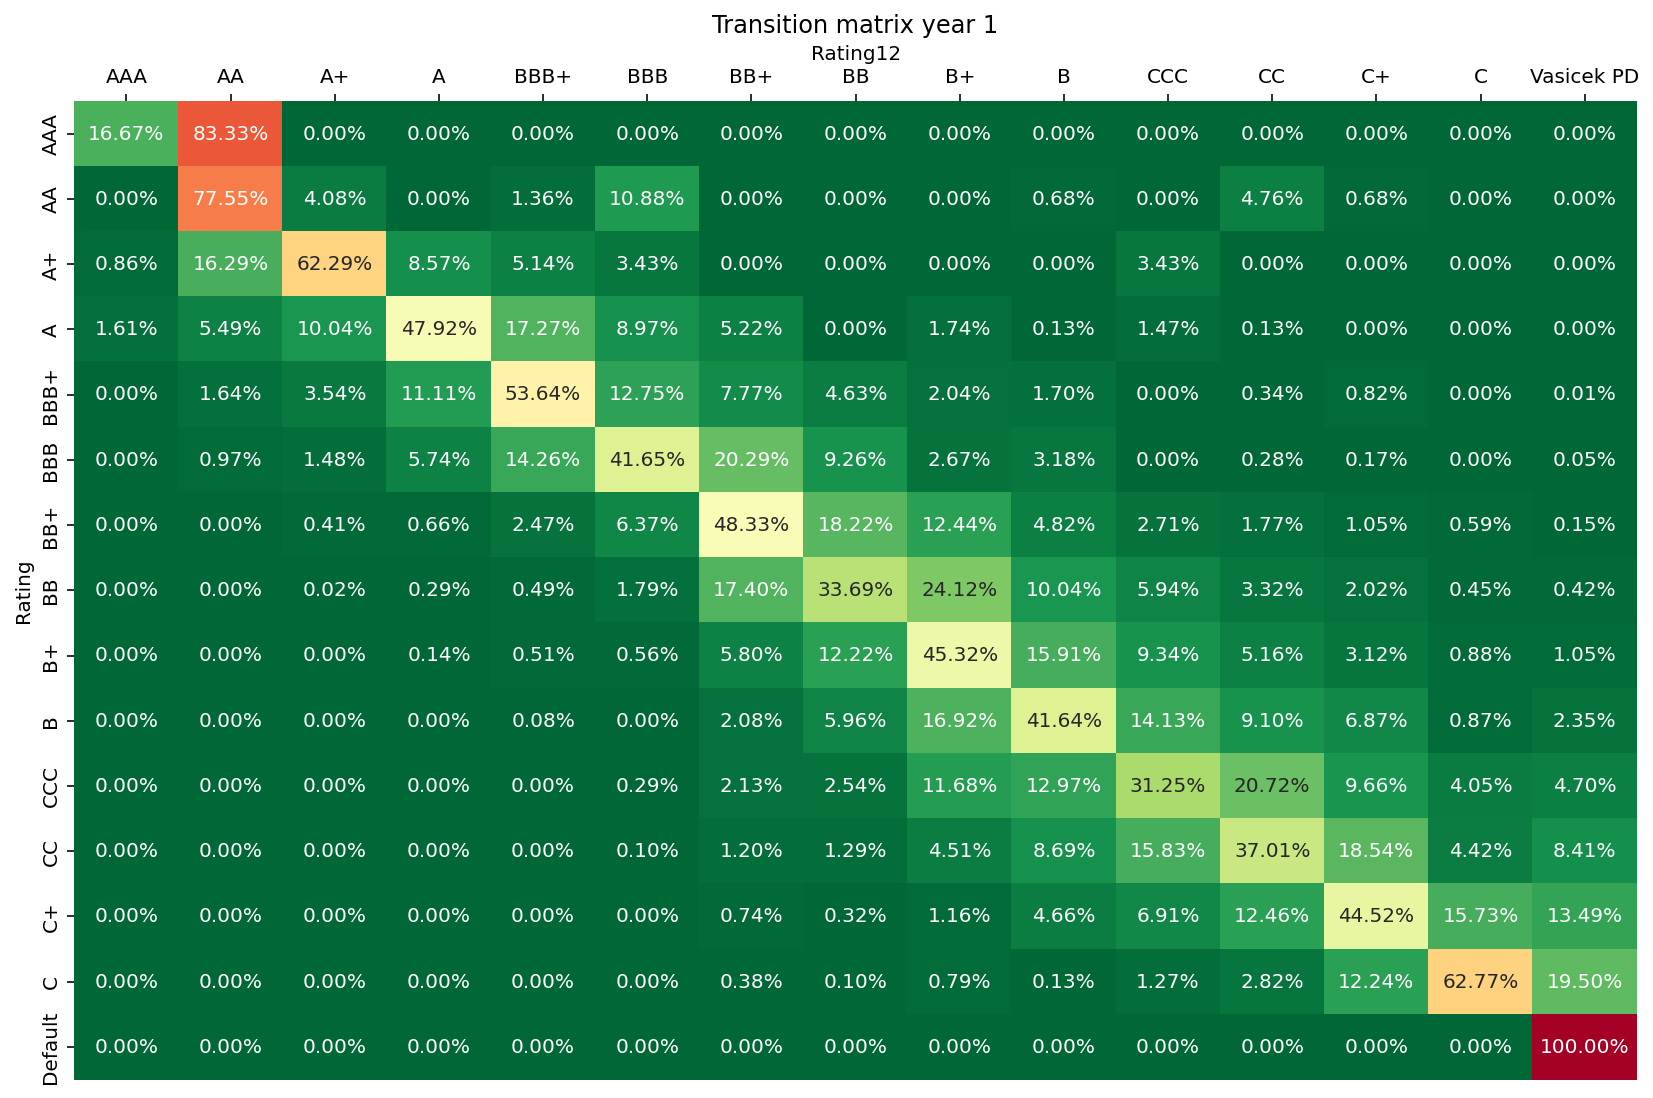

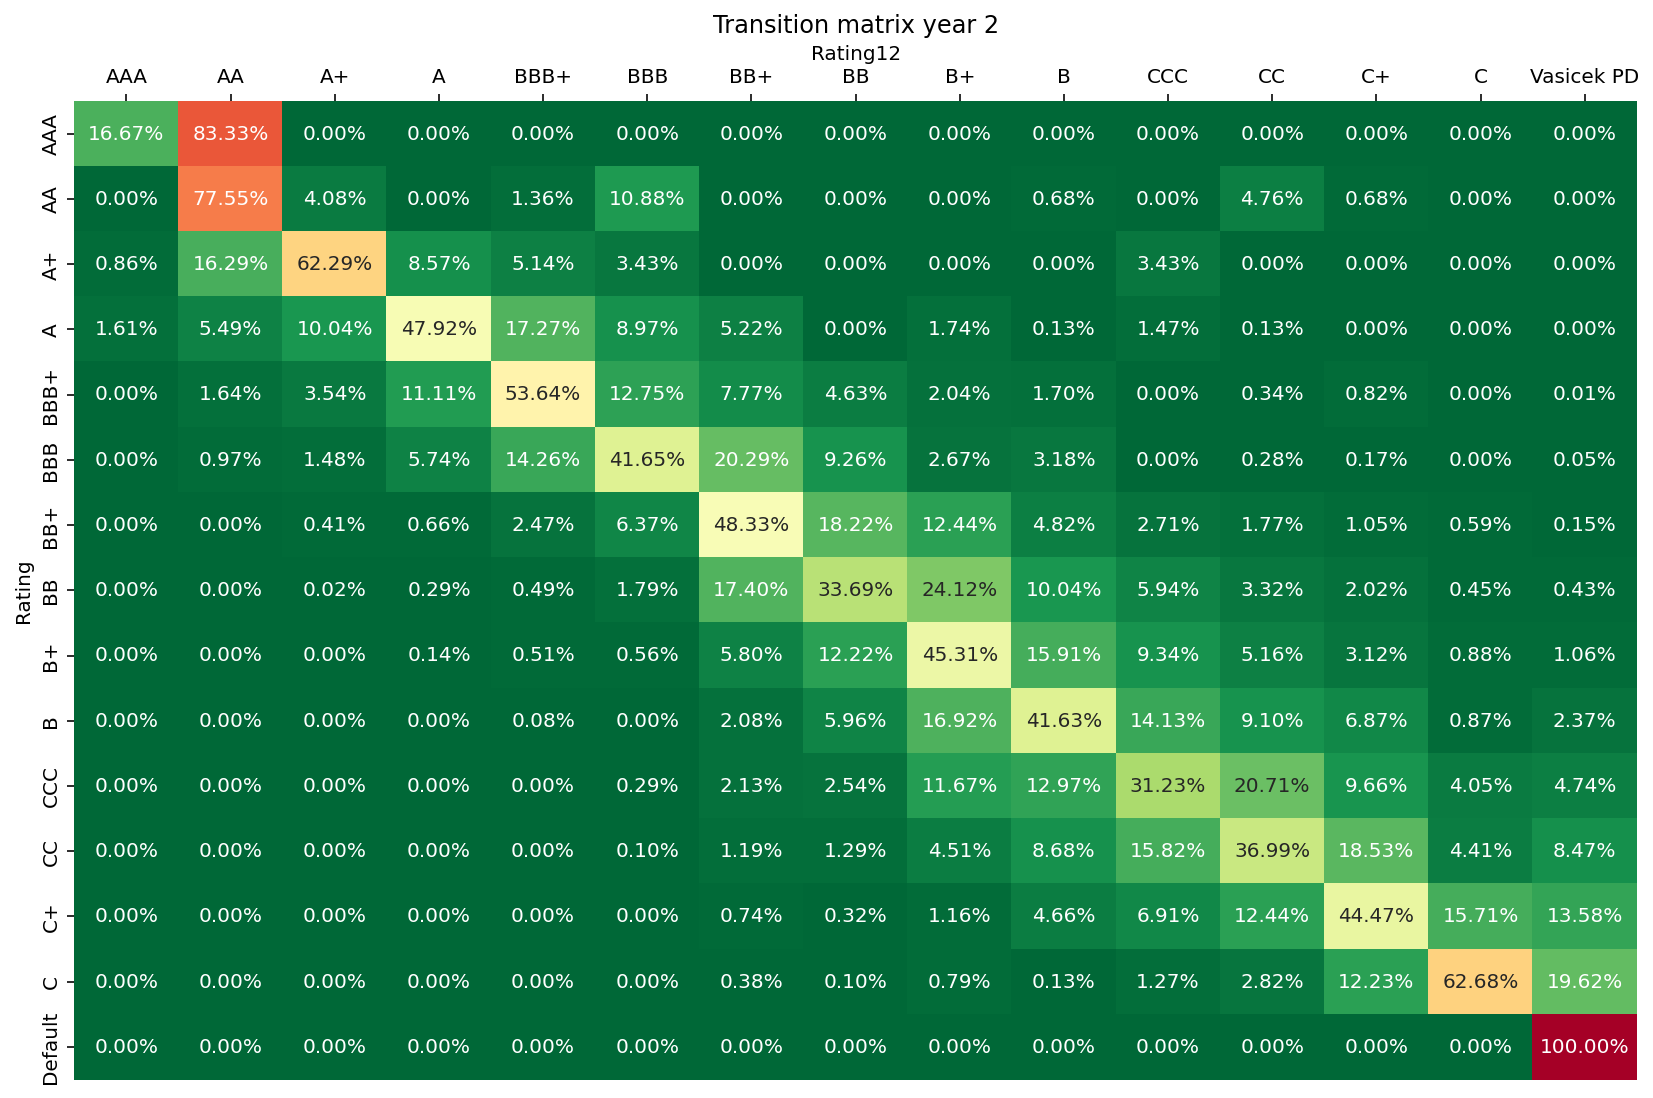

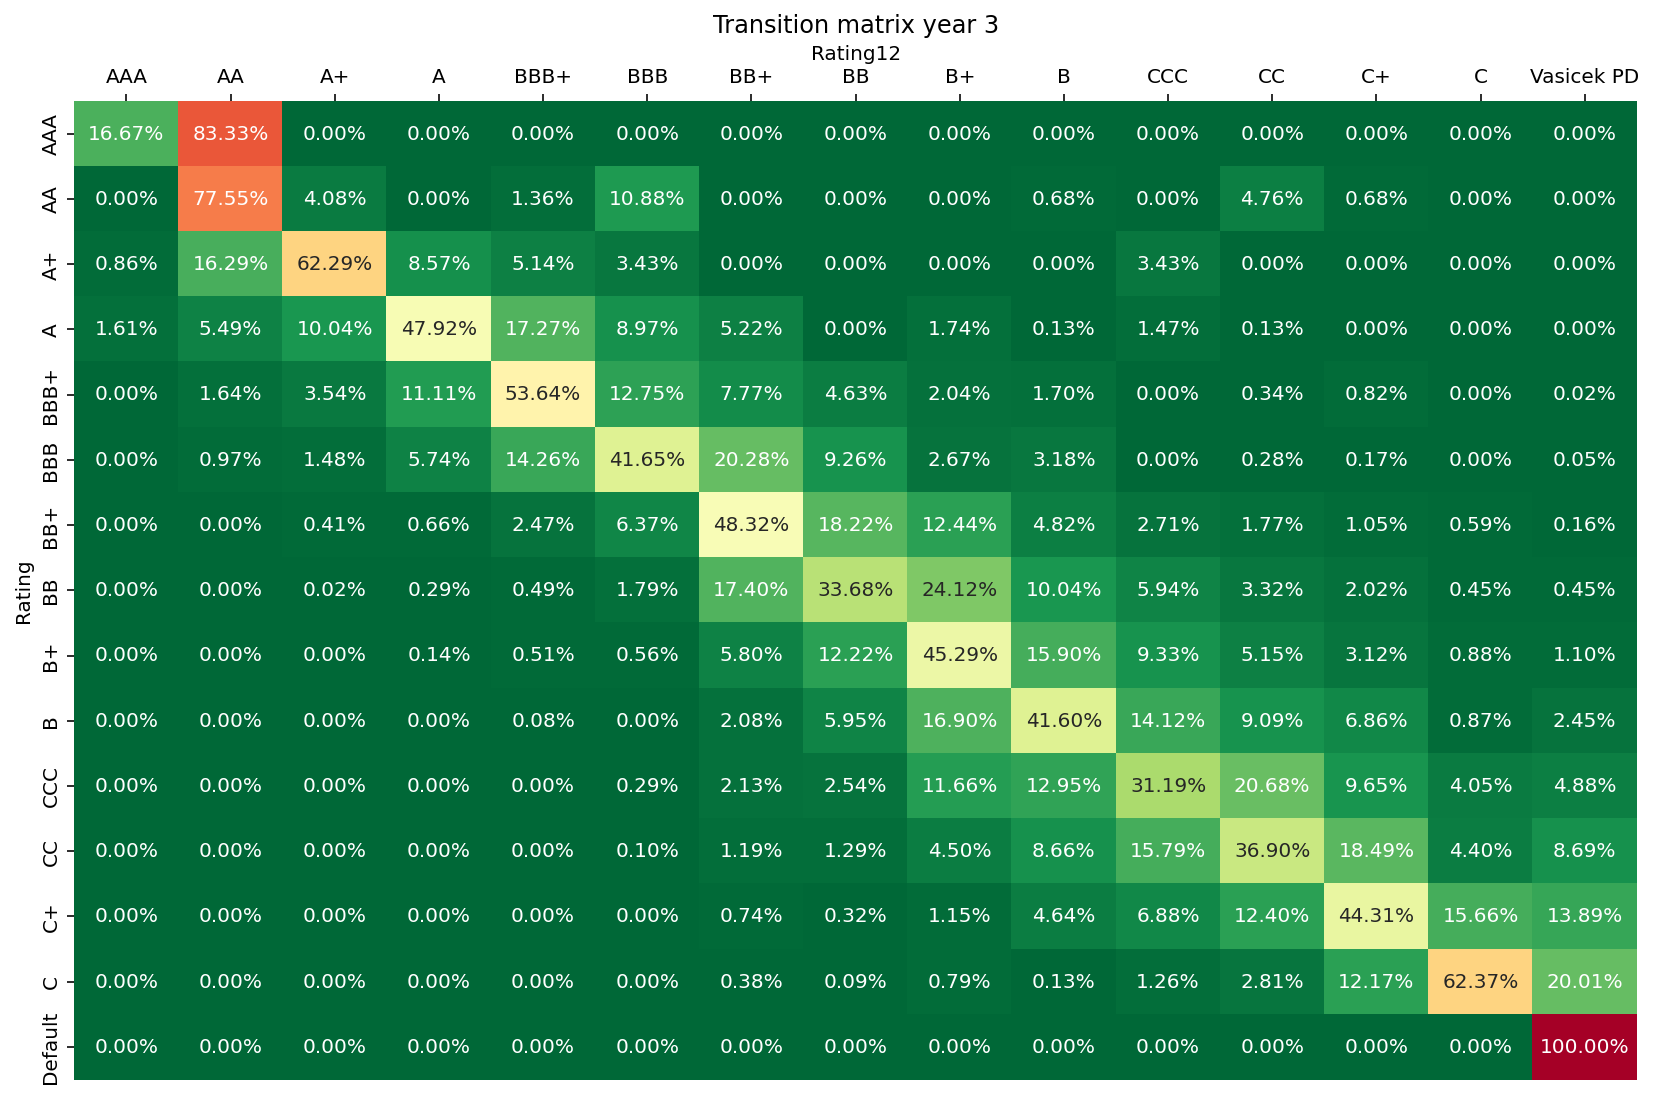

In [20]:
# Plot
for i in range(3):
  plotMatrix(matrixForecast[i], f'Transition matrix year {i + 1}')

In [21]:
# Matrix multiplication for lifetime
years = 15 #Create lifetime PD for 15-years
lifetimeResults = None

lifetime = matrixForecast[0].to_numpy() #Year 1 matrix as the based
lifetimePD = lifetime[:, -1][:-1] #Keep first year PD but not 'Default' row

for i in range(years):
  if i == 0:
    pass
  elif i < len(matrixForecast):
    lifetimeCum = np.matmul(
        lifetime[-len(indexRating):, :],
        matrixForecast[i]
    ) #Base * next year forecast
    lifetime = np.vstack((lifetime, lifetimeCum))
    lifetimePD = np.vstack((lifetimePD, lifetimeCum.iloc[:-1, -1])) #Keep only default bucket but not 'Default' row
    lifetimeResult = pd.DataFrame(
        lifetimePD,
        columns = indexRating[:-1]
    ) #Format to DataFrame
  else:
    lifetimeCum = np.matmul(
        lifetime[-len(indexRating):, :], #Latest forecasted matrix
        matrixForecast[0] #Base TTC Matrix
    ) #Mean reversion
    lifetime = np.vstack((lifetime, lifetimeCum)) #Keep cumulative matrix
    lifetimePD = np.vstack((lifetimePD, lifetimeCum.iloc[:-1, -1])) #Keep only default bucket but not 'Default' row
    lifetimeResult = pd.DataFrame(
        lifetimePD,
        columns = indexRating[:-1]
    ) #Format to DataFrame
if lifetimeResults is None:
  lifetimeResults = lifetimeResult.copy()
else:
  lifetimeResults = pd.concat(
      [lifetimeResults, lifetimeResult],
      axis = 0,
      ignore_index = False
  ) #Keep index

In [22]:
# Long table format
lifetimeResults['times'] = pd.date_range(
    start = '1/12/2018',
    periods = years,
    freq = 'Y'
)
lifetimeResults = pd.melt(
    lifetimeResults,
    id_vars = 'times',
    var_name = 'Rating',
    value_name = 'Cumulative PD'
)
lifetimeResults.head(5)

,times,Rating,Cumulative PD
0,2018-12-31,AAA,3.705910e-07
1,2019-12-31,AAA,2.072311e-06
2,2020-12-31,AAA,4.429783e-03
3,2021-12-31,AAA,1.253133e-02
4,2022-12-31,AAA,2.385485e-02


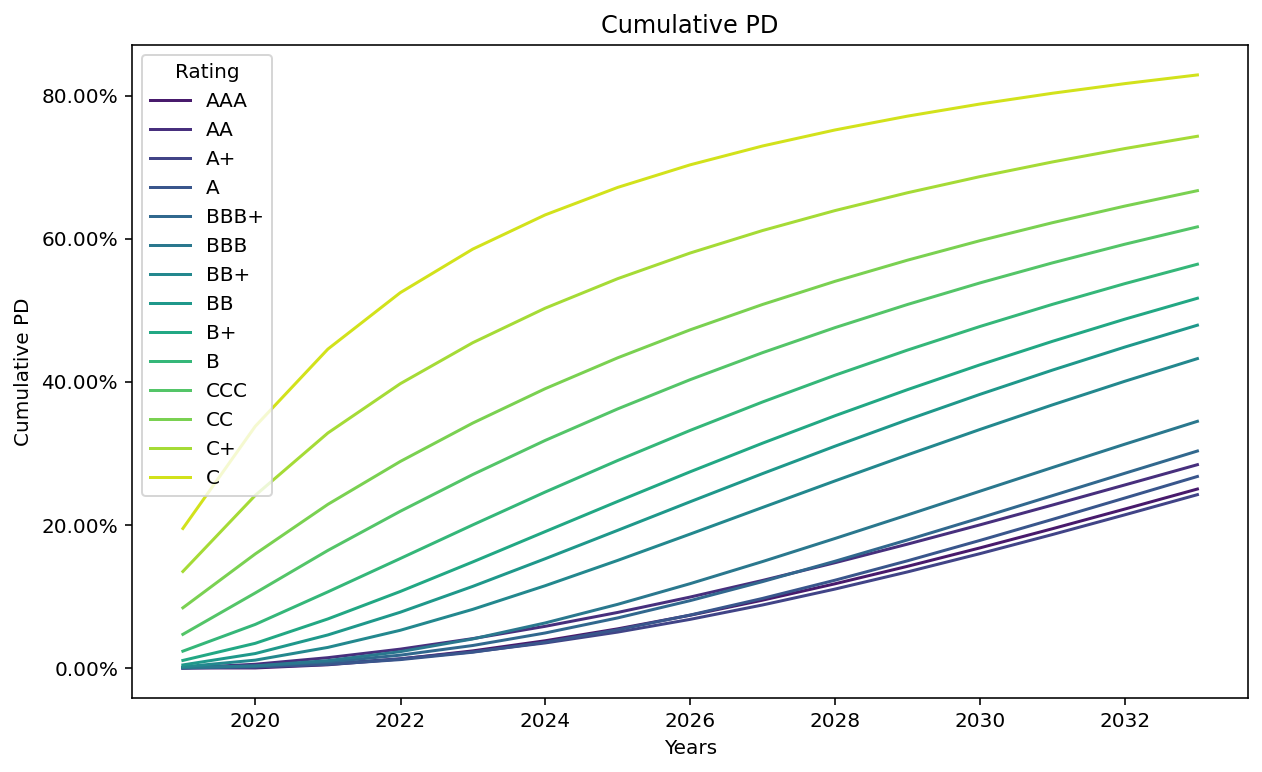

In [23]:
# Plot
plt.figure(figsize = (10, 6))
ax = sns.lineplot(
    x = 'times',
    y = 'Cumulative PD',
    data = lifetimeResults,
    hue = 'Rating',
    legend = 'full',
    palette = 'viridis',
    ci = None
)
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: '{0:.2f}%'.format(x * 100))
)
ax.set_title('Cumulative PD')
ax.set(xlabel = 'Years', ylabel = 'Cumulative PD')
plt.show()